In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import time
import datetime
import seaborn as sn
import heapq

In [3]:
index_choice = 'sp500'

In [4]:
SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [5]:
file_path = os.path.join("temp",f"{index_choice}",f"{index_choice}_final_smoothed.csv")
final_df = pd.read_csv(file_path)
final_df["datetime"] = final_df["date"].apply(lambda s: datetime.datetime.strptime(s, "%Y-%m-%d"))

In [6]:
def normalize (df):
    min = df.min()
    max = df.max()
    x = df
    y = (x-min) / (max-min)
    return y

In [7]:
industry_choice = ["Airlines","Internet Retail", "Electronic Gaming & Multimedia"]

industry_extract = final_df[final_df["industry"].isin(industry_choice)]

industry_extract["normalized_open"]= industry_extract.groupby("ticker")["open_x"].apply(lambda x: normalize (x))

industry_extract_grouped = industry_extract.groupby(["datetime","industry"]).mean("normalized_open").reset_index()

In [8]:
final_df["normalized_open"]= final_df.groupby("ticker")["open_x"].apply(lambda x: normalize (x))

final_df["change_open"]= (final_df.groupby("ticker")["open_x"].apply(pd.Series.pct_change))

window_size= 7
final_df["weekly_rolling_avg_open"]= final_df.groupby("ticker").rolling(window=window_size, min_periods= 1)['change_open'].mean().reset_index(drop=True)

window_size= 30
final_df["monthly_rolling_avg_open"]= final_df.groupby("ticker").rolling(window=window_size, min_periods= 1)['change_open'].mean().reset_index(drop=True)

open_by_stock = final_df.pivot(index="datetime", columns="ticker", values="normalized_open")

final_df.head()

date     open_x       high        low      close   adjclose  \
0  2019-01-02  31.459999  32.650002  31.049999  32.480000  31.963160   
1  2019-01-03  31.690001  31.850000  28.809999  30.059999  29.581665   
2  2019-01-04  30.440001  32.090000  30.400000  32.040001  31.530161   
3  2019-01-07  31.990000  33.480000  31.240000  32.950001  32.425678   
4  2019-01-08  33.360001  33.650002  32.200001  32.419998  31.904110   

     volume_x ticker    zip       sector  ...  address2 underlyingSymbol  \
0   5229500.0    AAL  76155  Industrials  ...       NaN              NaN   
1  16822000.0    AAL  76155  Industrials  ...       NaN              NaN   
2   9369600.0    AAL  76155  Industrials  ...       NaN              NaN   
3   8010700.0    AAL  76155  Industrials  ...       NaN              NaN   
4   7107700.0    AAL  76155  Industrials  ...       NaN              NaN   

  underlyingExchangeSymbol headSymbol uuid   datetime change_open  \
0                      NaN        NaN  NaN 2019-01-02         NaN   
1                      NaN        NaN  NaN 2019-01-03    0.007311   
2                      NaN        NaN  NaN 2019-01-04   -0.039445   
3                      NaN        NaN  NaN 2019-01-07    0.050920   
4                      NaN        NaN  NaN 2019-01-08    0.042826   

  weekly_rolling_avg_open  monthly_rolling_avg_open normalized_open  
0                     NaN                       NaN        0.809201  
1               -0.014586                 -0.014586        0.817404  
2               -0.018281                 -0.018281        0.772825  
3               -0.004125                 -0.004125        0.828103  
4                0.004333                  0.004333        0.876961  

[5 rows x 141 columns]

In [9]:
covid_usa = pd.read_csv("covid_usa_smoothed.csv")

covid_usa["datetime"] = covid_usa["date"].apply(lambda s: datetime.datetime.strptime(s, "%d/%m/%Y"))

#covid_usa.info()

final_df_covid = final_df.merge(covid_usa, how = "left", left_on= "datetime", right_on="datetime")

final_df_covid=final_df_covid.loc[final_df_covid["datetime"]>="2020-03-01"]

final_df_covid.head(20)

date_x     open_x       high        low      close   adjclose  \
292  2020-03-02  19.049999  19.059999  17.510000  18.860001  18.860001   
293  2020-03-03  19.660000  19.790001  17.799999  17.850000  17.850000   
294  2020-03-04  18.360001  18.549999  17.299999  18.530001  18.530001   
295  2020-03-05  17.540001  17.650000  15.980000  16.040001  16.040001   
296  2020-03-06  15.020000  17.120001  14.800000  15.970000  15.970000   
297  2020-03-09  14.870000  15.790000  14.460000  14.750000  14.750000   
298  2020-03-10  15.820000  17.670000  14.610000  17.000000  17.000000   
299  2020-03-11  16.309999  16.490000  15.520000  16.260000  16.260000   
300  2020-03-12  14.050000  15.750000  13.330000  13.450000  13.450000   
301  2020-03-13  15.300000  15.600000  13.120000  14.310000  14.310000   
302  2020-03-16  12.410000  16.200001  12.000000  15.920000  15.920000   
303  2020-03-17  15.790000  18.490000  14.790000  15.580000  15.580000   
304  2020-03-18  14.240000  14.280000  10.170000  11.650000  11.650000   
305  2020-03-19  11.600000  12.160000  10.010000  10.290000  10.290000   
306  2020-03-20  10.650000  12.000000  10.300000  10.380000  10.380000   
307  2020-03-23  10.900000  11.360000  10.010000  10.250000  10.250000   
308  2020-03-24  11.960000  14.810000  11.540000  13.920000  13.920000   
309  2020-03-25  16.690001  16.990000  14.310000  15.390000  15.390000   
310  2020-03-26  16.059999  17.240000  15.160000  15.660000  15.660000   
311  2020-03-27  14.980000  15.220000  13.910000  14.040000  14.040000   

        volume_x ticker    zip       sector  ...  cardiovasc_death_rate  \
292   38738000.0    AAL  76155  Industrials  ...                151.089   
293   35402500.0    AAL  76155  Industrials  ...                151.089   
294   44362100.0    AAL  76155  Industrials  ...                151.089   
295   44656800.0    AAL  76155  Industrials  ...                151.089   
296   54505000.0    AAL  76155  Industrials  ...                151.089   
297   42558000.0    AAL  76155  Industrials  ...                151.089   
298   56972700.0    AAL  76155  Industrials  ...                151.089   
299   43705800.0    AAL  76155  Industrials  ...                151.089   
300   53968500.0    AAL  76155  Industrials  ...                151.089   
301   58376100.0    AAL  76155  Industrials  ...                151.089   
302   84916800.0    AAL  76155  Industrials  ...                151.089   
303   58055800.0    AAL  76155  Industrials  ...                151.089   
304   78458800.0    AAL  76155  Industrials  ...                151.089   
305   71584500.0    AAL  76155  Industrials  ...                151.089   
306   62681800.0    AAL  76155  Industrials  ...                151.089   
307   56427300.0    AAL  76155  Industrials  ...                151.089   
308  101553100.0    AAL  76155  Industrials  ...                151.089   
309   93795100.0    AAL  76155  Industrials  ...                151.089   
310   77530600.0    AAL  76155  Industrials  ...                151.089   
311   50783500.0    AAL  76155  Industrials  ...                151.089   

    diabetes_prevalence female_smokers male_smokers handwashing_facilities  \
292               10.79           19.1         24.6                    NaN   
293               10.79           19.1         24.6                    NaN   
294               10.79           19.1         24.6                    NaN   
295               10.79           19.1         24.6                    NaN   
296               10.79           19.1         24.6                    NaN   
297               10.79           19.1         24.6                    NaN   
298               10.79           19.1         24.6                    NaN   
299               10.79           19.1         24.6                    NaN   
300               10.79           19.1         24.6                    NaN   
301               10.79           19.1         24.6                    NaN   
302               10

In [10]:
### correlation matrix between new cases and open_x (absolute values)

df_corr_stock = final_df_covid.pivot(index="datetime", columns="ticker", values="open_x")

df_corr_covid = final_df_covid.pivot(index="datetime", columns="ticker", values="new_cases")

correlation_list= {}

for ticker in df_corr_stock:
    correlation = df_corr_stock[ticker].corr(df_corr_covid[ticker], method="pearson")
    correlation_list[ticker]=correlation

print(correlation_list)

{'A': 0.68585596004682, 'AAL': -0.2837806950597591, 'AAP': 0.5461349815576194, 'AAPL': 0.6155642036982544, 'ABBV': 0.6090432979185478, 'ABC': 0.7461548050943353, 'ABMD': 0.7550915485608615, 'ABT': 0.658129807997142, 'ACN': 0.6871962494173985, 'ADBE': 0.6697335350145023, 'ADI': 0.5467838166176515, 'ADM': 0.5657081551754463, 'ADP': 0.07025921026900835, 'ADSK': 0.6920977624632955, 'AEE': 0.2940545201562532, 'AEP': -0.06973364794394564, 'AES': 0.40957401649028324, 'AFL': 0.05885922984441832, 'AIG': 0.07527679025745415, 'AIV': -0.26412747269832515, 'AIZ': 0.21215064855655405, 'AJG': 0.5521825335279835, 'AKAM': 0.8210090970440439, 'ALB': 0.49014873974774664, 'ALGN': 0.6692598277110706, 'ALK': 0.03160704491197352, 'ALL': -0.11646090334487479, 'ALLE': -0.0327072183219984, 'ALXN': 0.4959370974734664, 'AMAT': 0.6582899710230262, 'AMCR': 0.658208928217096, 'AMD': 0.5482317859397723, 'AME': 0.5472599299285031, 'AMGN': 0.796705369788087, 'AMP': 0.5894221904826008, 'AMT': 0.5516034226679257, 'AMZN':

In [11]:
### finding the max and min correlation values
correlation_list_abs={}
for ticker in correlation_list:
    correlation_list_abs[ticker]=abs(correlation_list[ticker])

weakest_corr=heapq.nsmallest(10,correlation_list_abs,key=correlation_list_abs.get)
strongest_corr=heapq.nlargest(10,correlation_list_abs,key=correlation_list_abs.get)

print(weakest_corr)
print(strongest_corr)

['CBRE', 'USB', 'LW', 'SJM', 'KEY', 'BA', 'PNC', 'CINF', 'HIG', 'DVN']
['AKAM', 'CLX', 'RMD', 'TER', 'EA', 'MSCI', 'AMGN', 'XLNX', 'NFLX', 'AMZN']


In [12]:
for x in weakest_corr:
    print(correlation_list_abs[x])

for y in strongest_corr:
    print(correlation_list_abs[y])

5.9638828310779315e-05
0.0017643849778206022
0.0020347533631903136
0.0054655202856303845
0.0077547714410221005
0.010572005327341708
0.011158303677639205
0.01500278725914235
0.015124797145911155
0.01600019982381894
0.8210090970440439
0.816564744920318
0.8152210103327363
0.8126030636046044
0.8103006939836876
0.7990846934427966
0.796705369788087
0.794592858435391
0.7935777325544989
0.7821475443531719


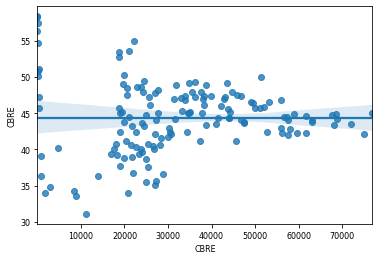

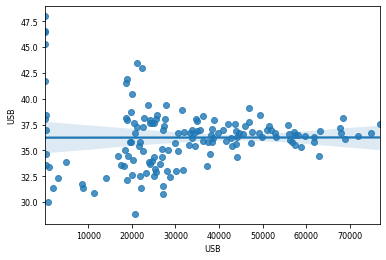

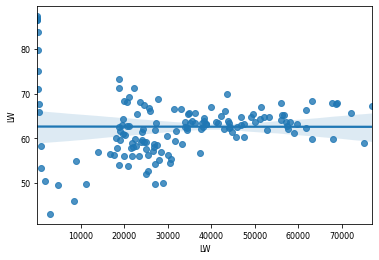

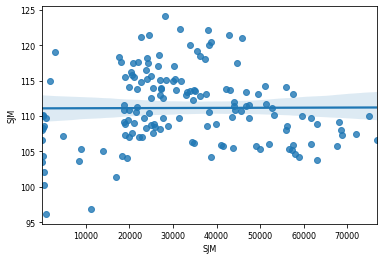

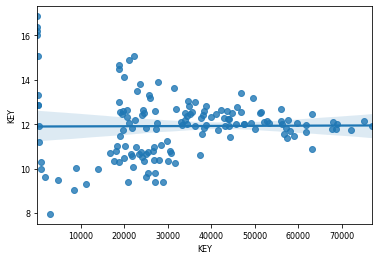

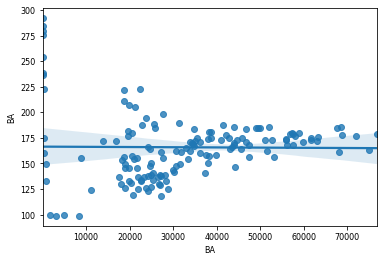

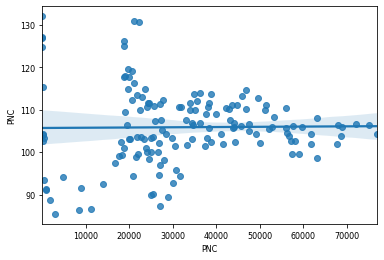

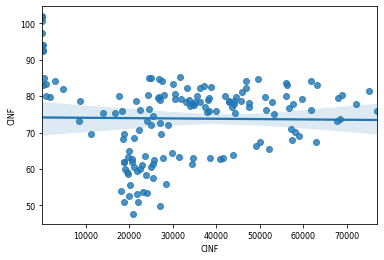

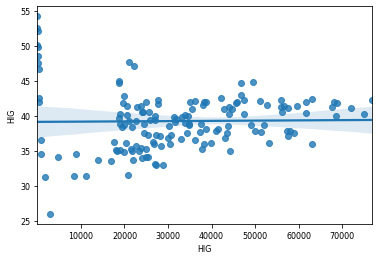

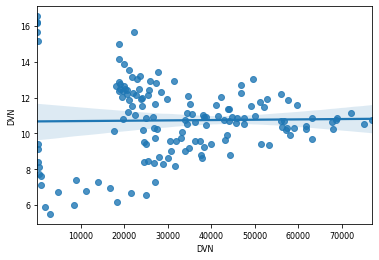

In [24]:
## corr between new_cases and open_x--> weakest correlations

for x in weakest_corr:
    df_corr_x=final_df_covid.loc[final_df_covid["ticker"]==x].loc[final_df_covid["datetime"]>="2020-03-01"]
    df_corr_joint_x = df_corr_x.pivot(index="datetime", columns="ticker", values=["open_x", "new_cases"])
    plt.figure()
    sn.regplot(x=df_corr_joint_x["new_cases"], y=df_corr_joint_x["open_x"], fit_reg=True, label="ticker")


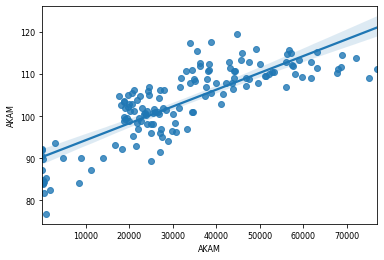

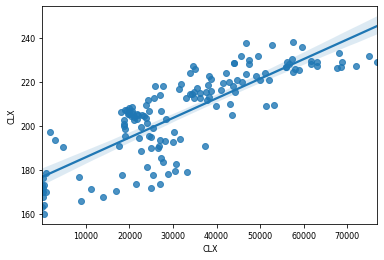

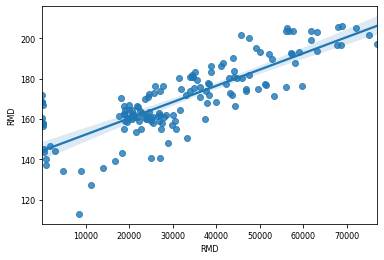

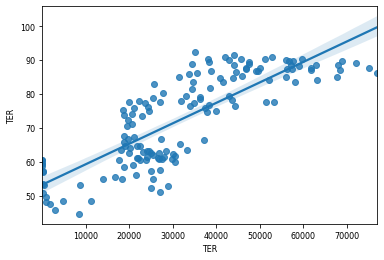

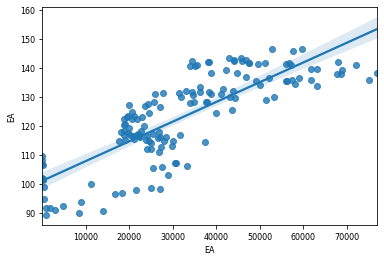

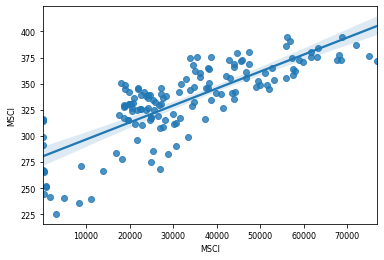

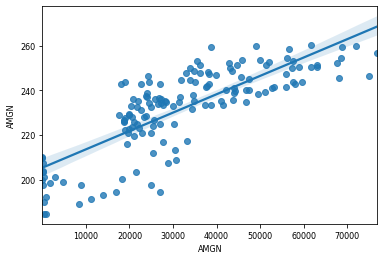

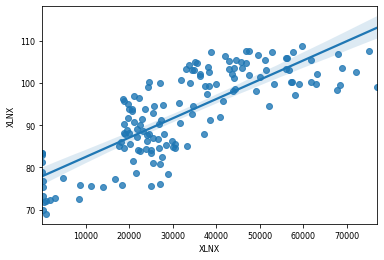

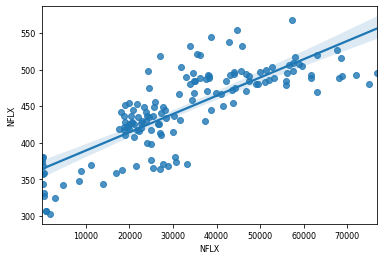

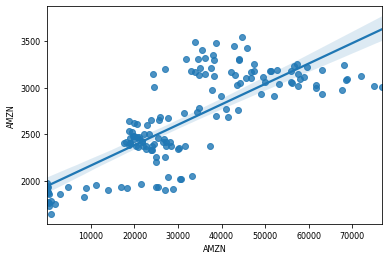

In [23]:
## corr between new_cases and open_x--> strongest correlations

for y in strongest_corr:
    df_corr_y=final_df_covid.loc[final_df_covid["ticker"]==y].loc[final_df_covid["datetime"]>="2020-03-01"]
    df_corr_joint_y = df_corr_y.pivot(index="datetime", columns="ticker", values=["open_x", "new_cases"])
    plt.figure()
    sn.regplot(x=df_corr_joint_y["new_cases"], y=df_corr_joint_y["open_x"], fit_reg=True, label="ticker")

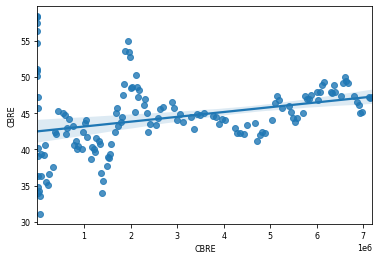

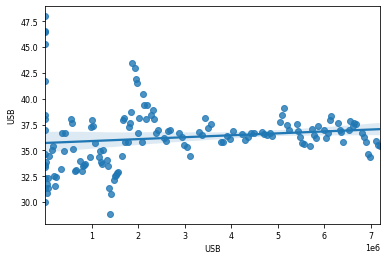

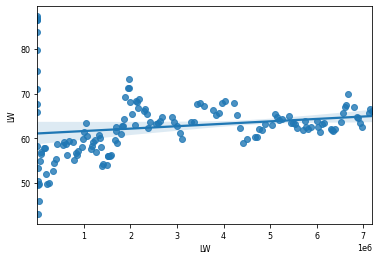

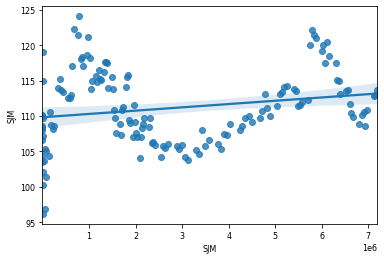

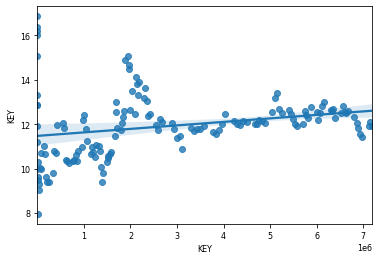

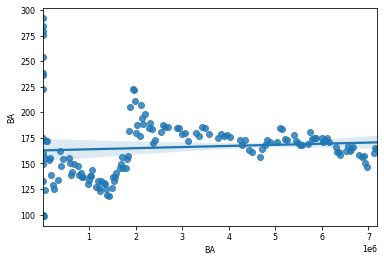

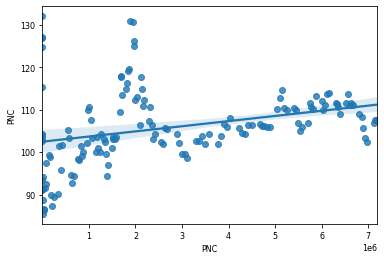

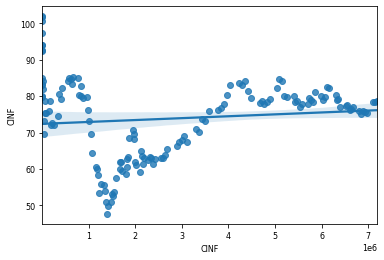

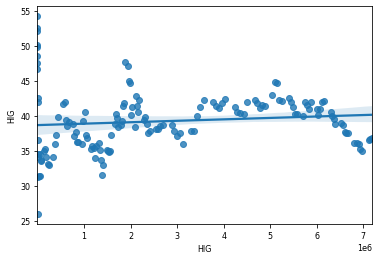

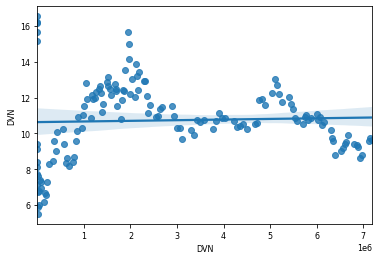

In [42]:
## corr between total_cases and open_x--> weakest correlations

for x in weakest_corr:
    df_corr_x=final_df_covid.loc[final_df_covid["ticker"]==x].loc[final_df_covid["datetime"]>="2020-03-01"]
    df_corr_joint_x = df_corr_x.pivot(index="datetime", columns="ticker", values=["open_x", "total_cases"])
    plt.figure()
    sn.regplot(x=df_corr_joint_x["total_cases"], y=df_corr_joint_x["open_x"], fit_reg=True, label="ticker")


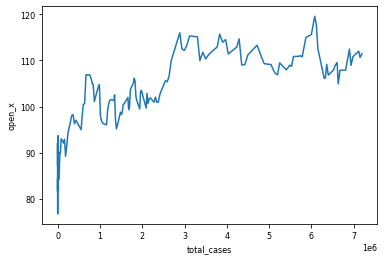

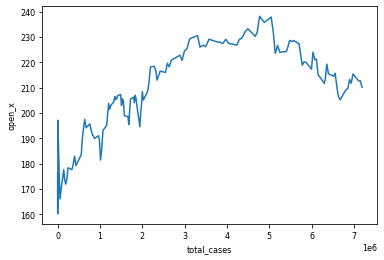

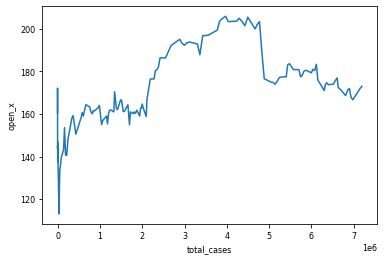

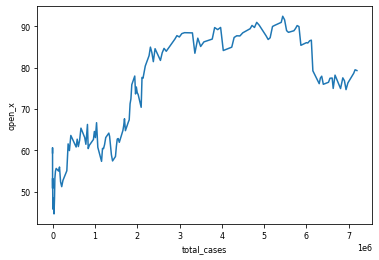

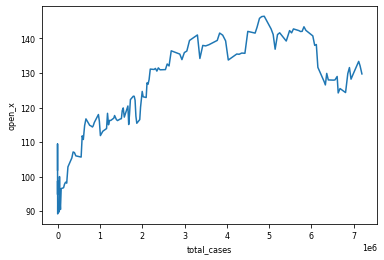

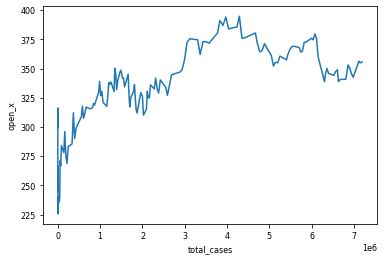

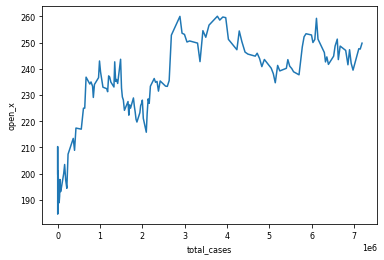

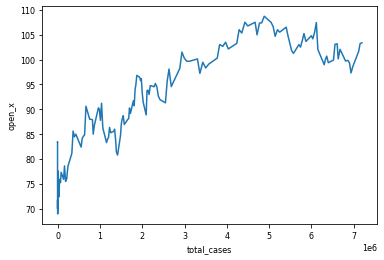

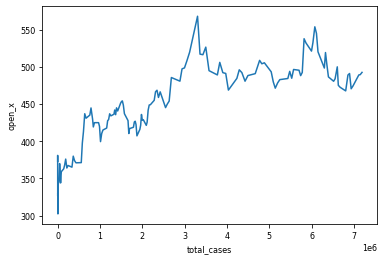

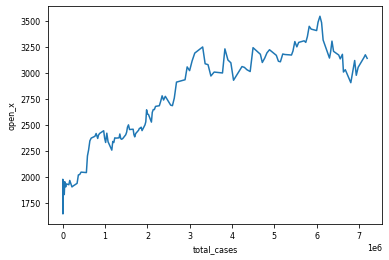

In [21]:
## corr between total_cases and open_x--> strongest correlations

for y in strongest_corr:
    df_corr_y=final_df_covid.loc[final_df_covid["ticker"]==y].loc[final_df_covid["datetime"]>="2020-03-01"]
    #df_corr_joint_y = df_corr_y.pivot(index="datetime", columns="ticker", values=["open_x", "total_cases"]).reset_index()
    plt.figure()
    sn.lineplot(x="total_cases", y="open_x", data=df_corr_y)

In [20]:
 df_corr_y.head(5)

date_x     open_x       high        low      close   adjclose  \
9553  2020-03-02  87.309998  90.919998  86.599998  90.910004  90.910004   
9554  2020-03-03  90.529999  93.089996  89.150002  90.279999  90.279999   
9555  2020-03-04  91.959999  95.000000  91.269997  94.900002  94.900002   
9556  2020-03-05  92.129997  93.860001  91.769997  92.980003  92.980003   
9557  2020-03-06  89.779999  91.190002  88.029999  90.620003  90.620003   

       volume_x ticker    zip      sector  ...  cardiovasc_death_rate  \
9553  1726600.0   AKAM  02142  Technology  ...                151.089   
9554  2616300.0   AKAM  02142  Technology  ...                151.089   
9555  1507100.0   AKAM  02142  Technology  ...                151.089   
9556  1903700.0   AKAM  02142  Technology  ...                151.089   
9557  2097200.0   AKAM  02142  Technology  ...                151.089   

     diabetes_prevalence female_smokers male_smokers handwashing_facilities  \
9553               10.79           19.1         24.6                    NaN   
9554               10.79           19.1         24.6                    NaN   
9555               10.79           19.1         24.6                    NaN   
9556               10.79           19.1         24.6                    NaN   
9557               10.79           19.1         24.6                    NaN   

     hospital_beds_per_thousand life_expectancy human_development_index  \
9553                       2.77           78.86                   0.924   
9554                       2.77           78.86                   0.924   
9555                       2.77           78.86                   0.924   
9556                       2.77           78.86                   0.924   
9557                       2.77           78.86                   0.924   

      change_new_cases rolling_avg_new_cases  
9553          5.666667              1.666667  
9554         -0.300000              1.338889  
9555          0.571429              1.600794  
9556          0.545455              1.450031  
9557          1.176471              1.737146  

[5 rows x 184 columns]

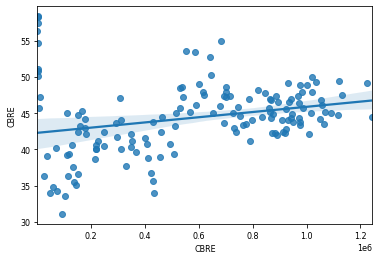

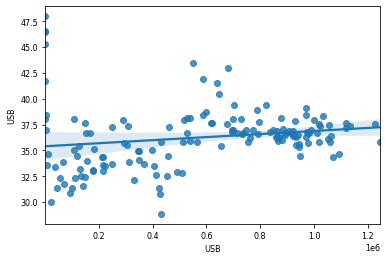

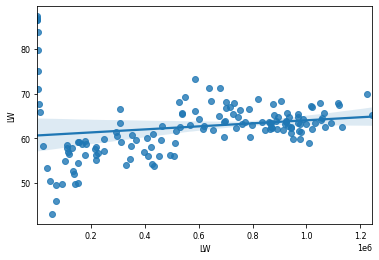

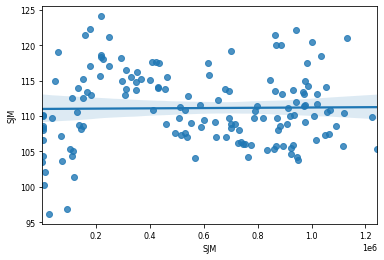

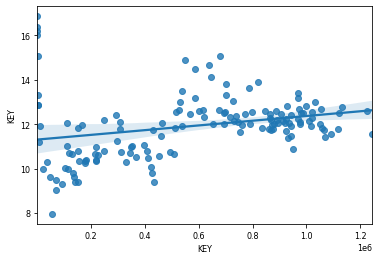

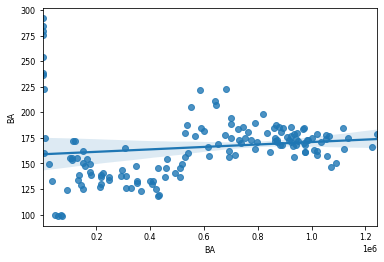

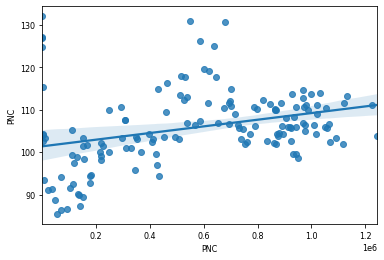

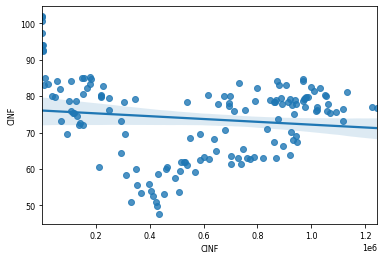

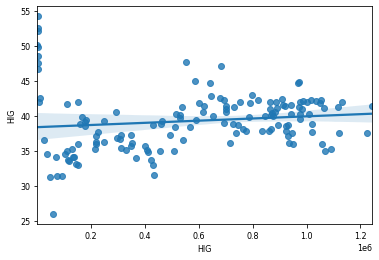

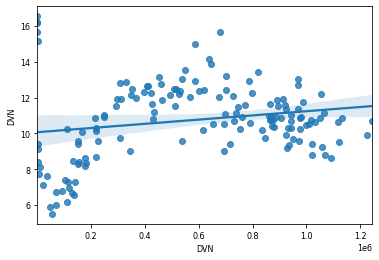

In [44]:
## corr between new_tests and open_x--> weakest correlations

for x in weakest_corr:
    df_corr_x=final_df_covid.loc[final_df_covid["ticker"]==x].loc[final_df_covid["datetime"]>="2020-03-01"]
    df_corr_joint_x = df_corr_x.pivot(index="datetime", columns="ticker", values=["open_x", "new_tests"])
    plt.figure()
    sn.regplot(x=df_corr_joint_x["new_tests"], y=df_corr_joint_x["open_x"], fit_reg=True, label="ticker")


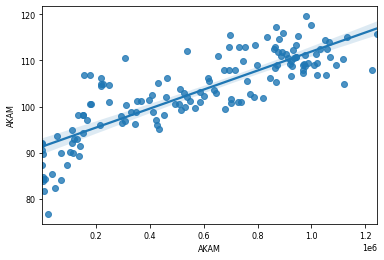

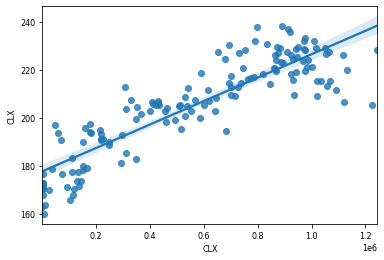

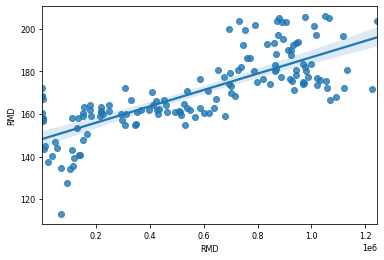

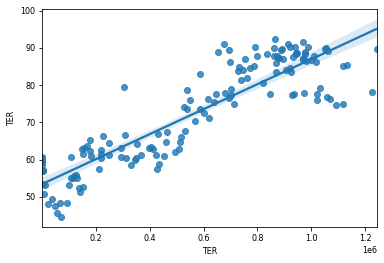

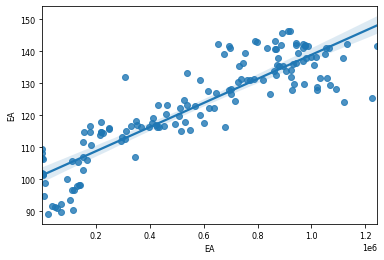

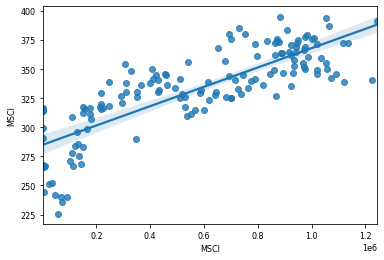

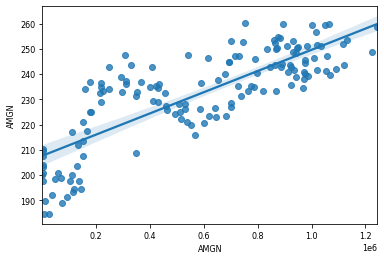

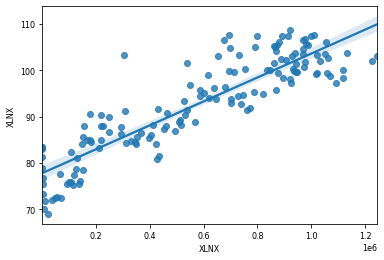

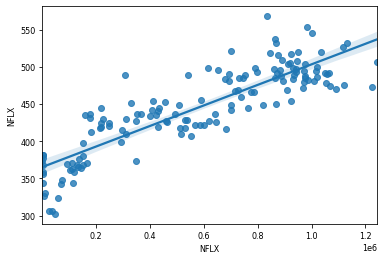

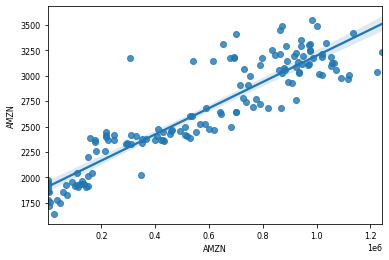

In [45]:
## corr between new_tests and open_x--> strongest correlations

for y in strongest_corr:
    df_corr_y=final_df_covid.loc[final_df_covid["ticker"]==y].loc[final_df_covid["datetime"]>="2020-03-01"]
    df_corr_joint_y = df_corr_y.pivot(index="datetime", columns="ticker", values=["open_x", "new_tests"])
    plt.figure()
    sn.regplot(x=df_corr_joint_y["new_tests"], y=df_corr_joint_y["open_x"], fit_reg=True)

In [68]:
def seaborn (stock_list, x_axis, y_axis):
    for x in stock_list:
        df=final_df_covid.loc[final_df_covid["ticker"]==x].loc[final_df_covid["datetime"]>="2020-03-01"]
        plt.figure()
        sn.set_theme(style="darkgrid")
        p = sn.jointplot(x=x_axis, y=y_axis, data=df,
                  kind="reg", truncate=False,
                  color="m", height=7, label=y)
        p.fig.suptitle(f"{x} open_x stock price against new cases")
    return

<Figure size 432x288 with 0 Axes>

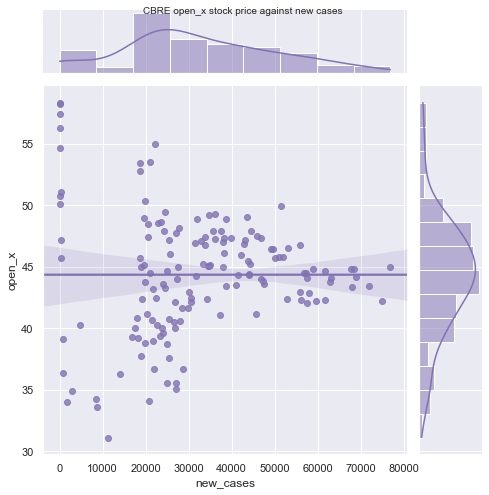

<Figure size 432x288 with 0 Axes>

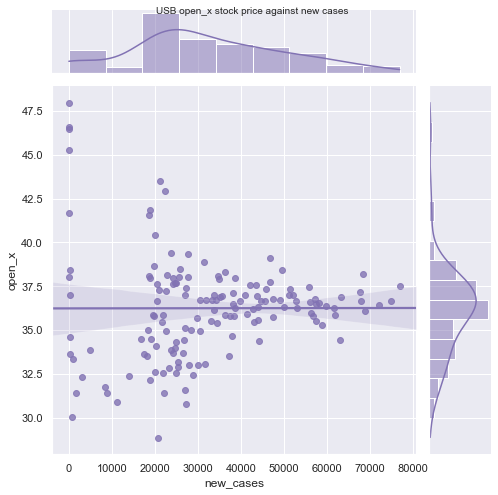

<Figure size 432x288 with 0 Axes>

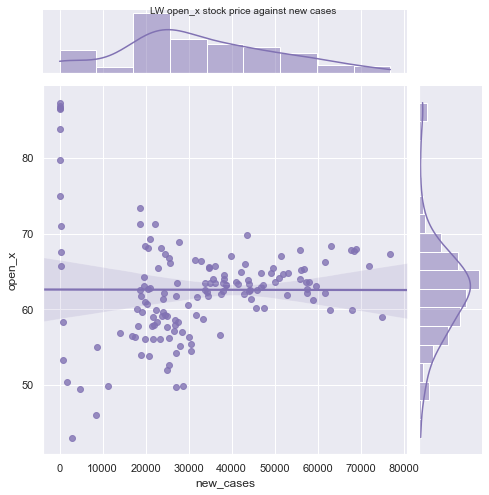

<Figure size 432x288 with 0 Axes>

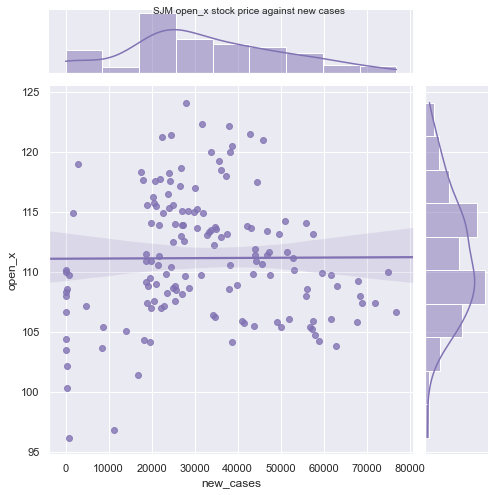

<Figure size 432x288 with 0 Axes>

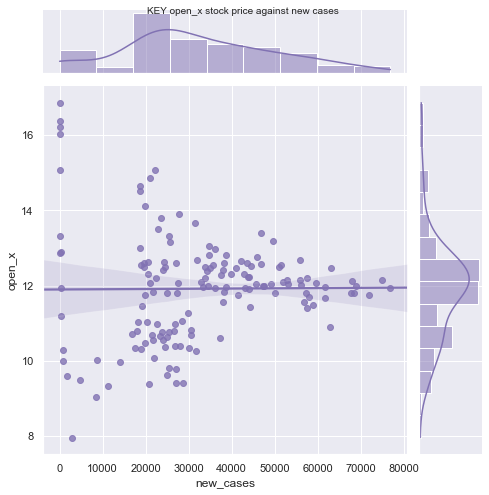

<Figure size 432x288 with 0 Axes>

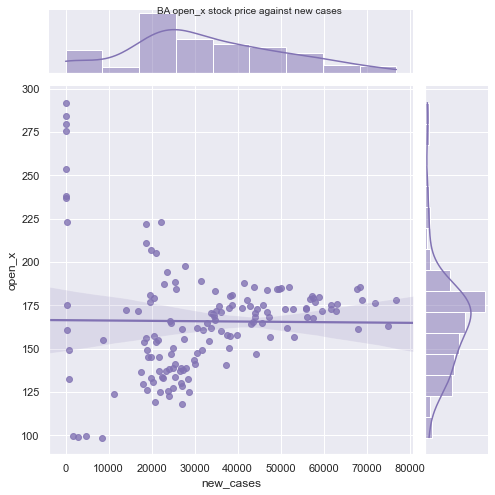

<Figure size 432x288 with 0 Axes>

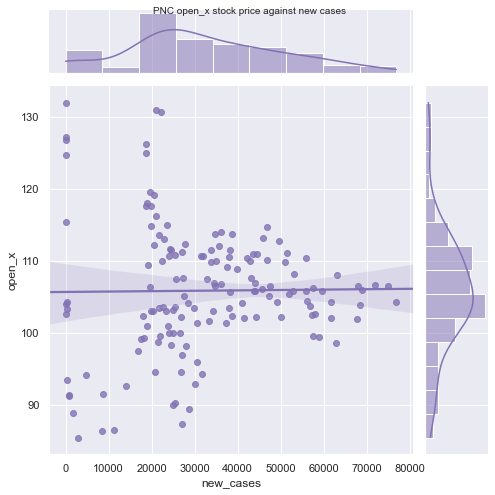

<Figure size 432x288 with 0 Axes>

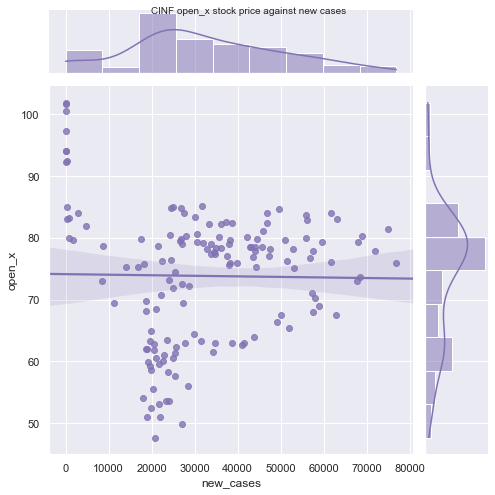

<Figure size 432x288 with 0 Axes>

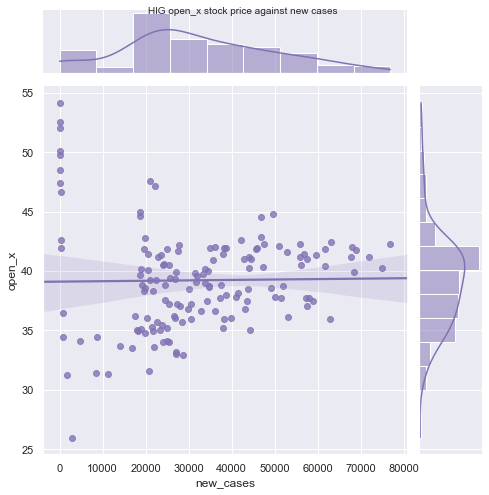

<Figure size 432x288 with 0 Axes>

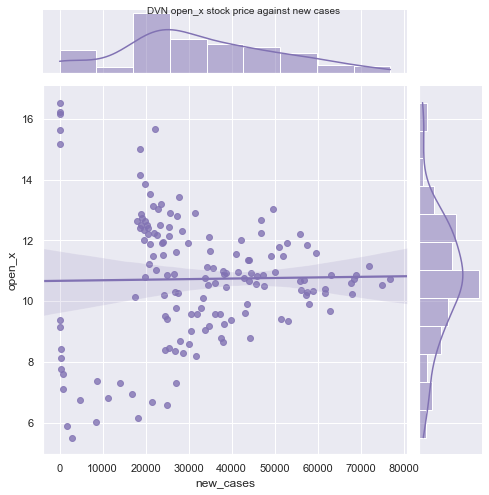

In [69]:
seaborn(weakest_corr, "new_cases", "open_x")

<Figure size 432x288 with 0 Axes>

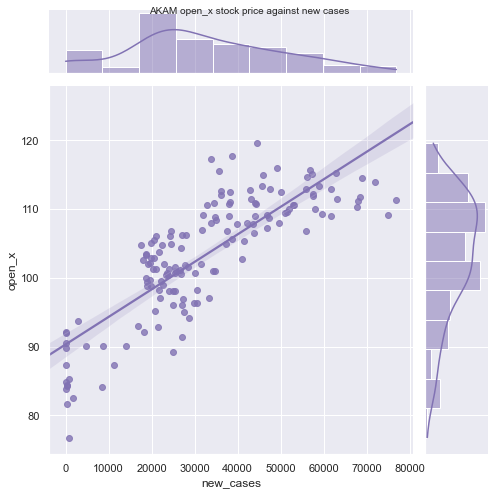

<Figure size 432x288 with 0 Axes>

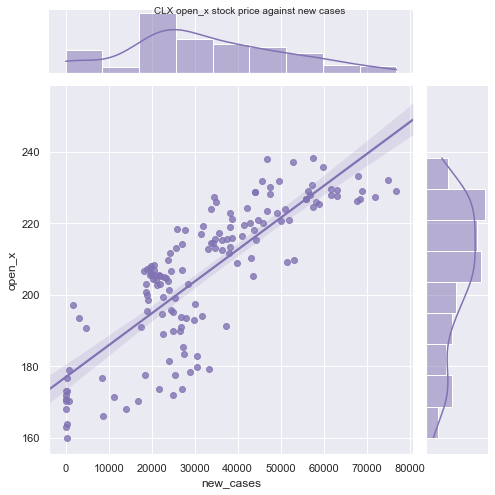

<Figure size 432x288 with 0 Axes>

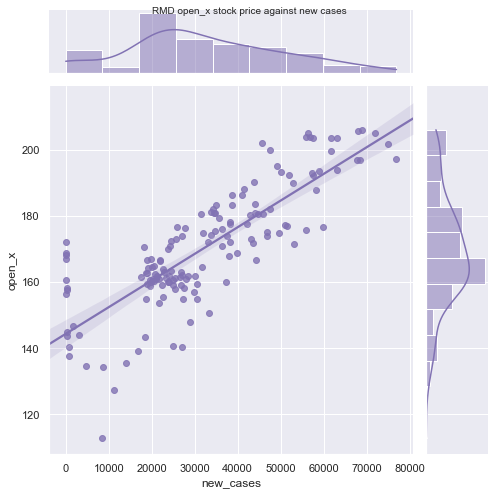

<Figure size 432x288 with 0 Axes>

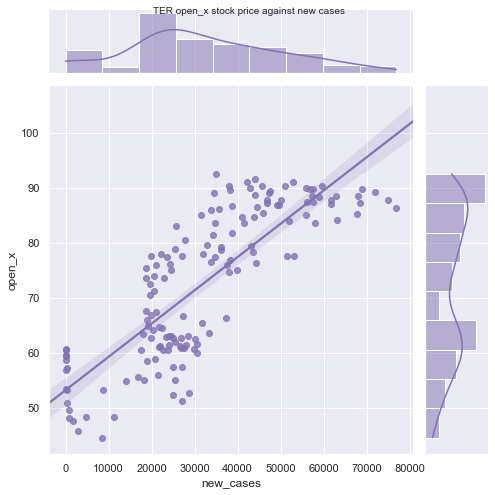

<Figure size 432x288 with 0 Axes>

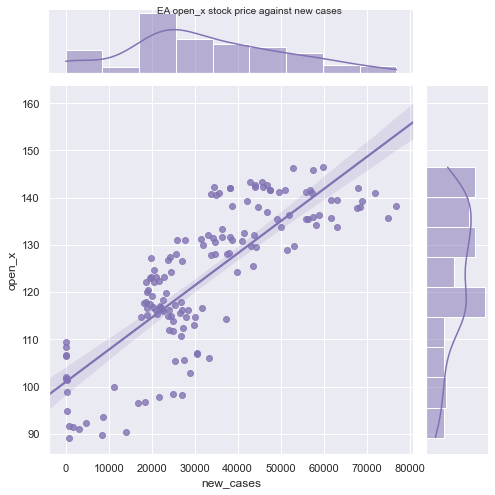

<Figure size 432x288 with 0 Axes>

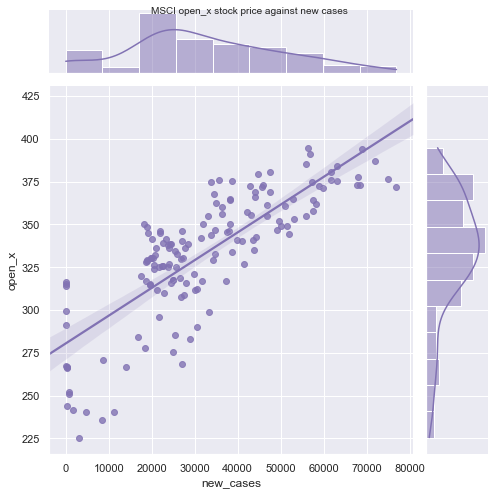

<Figure size 432x288 with 0 Axes>

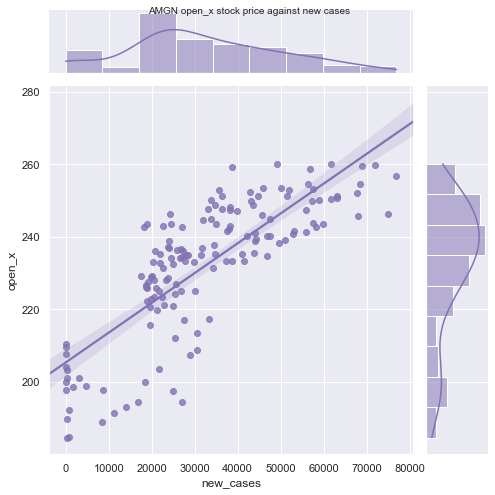

<Figure size 432x288 with 0 Axes>

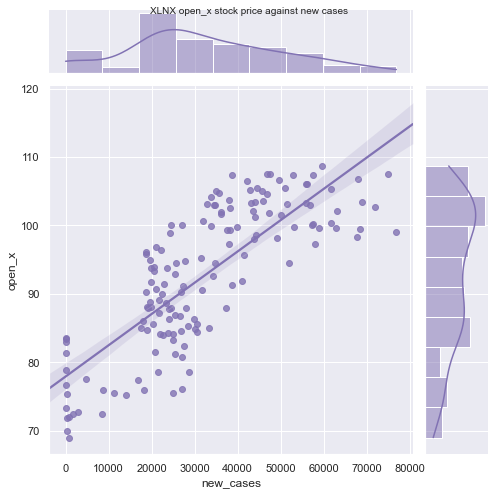

<Figure size 432x288 with 0 Axes>

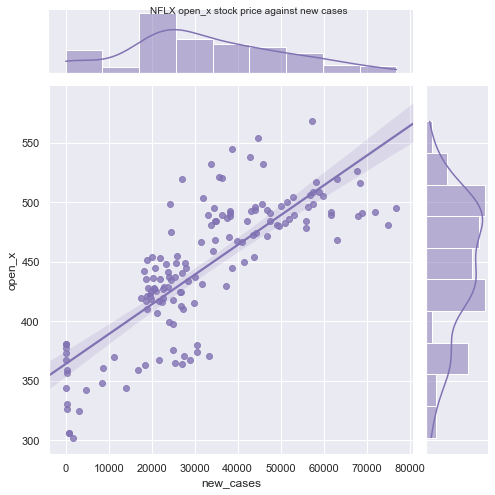

<Figure size 432x288 with 0 Axes>

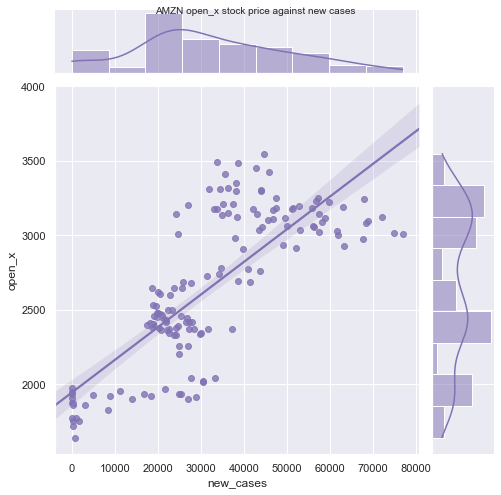

In [71]:
seaborn(strongest_corr, "new_cases", "open_x")

In [98]:
## calculating industry open_x correlation with covid new_cases

df_group_ind = final_df_covid.groupby(["industry", "datetime"]).mean().reset_index()
df_corr_ind=df_group_ind.pivot(index="datetime", columns="industry", values="open_x")

df_corr_ind_covid = df_group_ind.pivot(index="datetime", columns="industry", values="new_cases")

correlation_ind_list= {}

for industry in df_corr_ind:
    correlation = df_corr_ind[industry].corr(df_corr_ind_covid[industry], method="pearson")
    correlation_ind_list[industry]=correlation

print(correlation_ind_list)

{'Advertising Agencies': -0.2312916616677941, 'Aerospace & Defense': 0.08680156153057701, 'Agricultural Inputs': 0.557814830009581, 'Airlines': -0.20162225458011954, 'Apparel Manufacturing': -0.06433774846166056, 'Apparel Retail': 0.202356167563193, 'Asset Management': 0.6498077464428568, 'Auto & Truck Dealerships': 0.5275552411004564, 'Auto Manufacturers': 0.26872567324232316, 'Auto Parts': 0.5314187012126657, 'Banks—Diversified': -0.05216209214652931, 'Banks—Regional': 0.3085747095950968, 'Beverages—Brewers': -0.5641773104259552, 'Beverages—Non-Alcoholic': 0.5261981790778374, 'Beverages—Wineries & Distilleries': 0.5222504403604713, 'Biotechnology': 0.7343378894864725, 'Broadcasting': 0.20966562227915994, 'Building Materials': 0.47158353302766076, 'Building Products & Equipment': 0.42501403402759647, 'Business Equipment & Supplies': 0.43260248697822584, 'Capital Markets': 0.6672858471760718, 'Chemicals': 0.6527771850928282, 'Communication Equipment': 0.5775974318856362, 'Computer Hard